In [1]:
import cv2
import numpy as np
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow import keras
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.preprocessing.image import img_to_array

In [2]:
print("Please upload the OpenCV face detector weights file (.pb and .pbtxt files)")
uploaded = r'C:\Users\Salma\opencv_face_detector_uint8.pb'
uploaded1=r'C:\Users\Salma\opencv_face_detector.pbtxt'

Please upload the OpenCV face detector weights file (.pb and .pbtxt files)


In [3]:
#file contains pretrained model weights learned during the training process to recognize face features
pb_files = [filename for filename in os.listdir(os.path.dirname(uploaded)) if filename.endswith('.pb')]
#this file contains architecture of the face detector model(layers,params,...)
pbtxt_files = [filename for filename in os.listdir(os.path.dirname(uploaded1)) if filename.endswith('.pbtxt')]

In [4]:
# Load the OpenCV face detector model
detection_model = cv2.dnn.readNetFromTensorflow(pb_files[0], pbtxt_files[0])

In [5]:
data_path = 'C:\\Users\\Salma\\archive\\105_classes_pins_dataset\\'

# Collect all the person names
folders= os.listdir(data_path)
celebrities = [name.split("_")[-1].title() for name in folders]
nOfClasses = len(celebrities)

print(f"Total number of individuals: {nOfClasses}\n")
print(f"Name of the individuals : \n\t{celebrities}")

Total number of individuals: 105

Name of the individuals : 
	['Adriana Lima', 'Alex Lawther', 'Alexandra Daddario', 'Alvaro Morte', 'Alycia Dabnem Carey', 'Amanda Crew', 'Amber Heard', 'Andy Samberg', 'Anne Hathaway', 'Anthony Mackie', 'Avril Lavigne', 'Barack Obama', 'Barbara Palvin', 'Ben Affleck', 'Bill Gates', 'Bobby Morley', 'Brenton Thwaites', 'Brian J. Smith', 'Brie Larson', 'Camila Mendes', 'Chris Evans', 'Chris Hemsworth', 'Chris Pratt', 'Christian Bale', 'Cristiano Ronaldo', 'Danielle Panabaker', 'Dominic Purcell', 'Dwayne Johnson', 'Eliza Taylor', 'Elizabeth Lail', 'Elizabeth Olsen', 'Ellen Page', 'Elon Musk', 'Emilia Clarke', 'Emma Stone', 'Emma Watson', 'Gal Gadot', 'Grant Gustin', 'Gwyneth Paltrow', 'Henry Cavil', 'Hugh Jackman', 'Inbar Lavi', 'Irina Shayk', 'Jake Mcdorman', 'Jason Momoa', 'Jeff Bezos', 'Jennifer Lawrence', 'Jeremy Renner', 'Jessica Barden', 'Jimmy Fallon', 'Johnny Depp', 'Josh Radnor', 'Katharine Mcphee', 'Katherine Langford', 'Keanu Reeves', 'Kiernen S

In [6]:
#store paths for all images
filepaths = [path  for name in folders for path in glob(data_path + name + '/*')]

np.random.shuffle(filepaths)#shuffling helps in randomizing the data
print(f"Total number of images to be loaded : {len(filepaths)}")

IMG_W, IMG_H, IMG_C = (160, 160, 3)
# Create space for the images
preprocessed_images = np.empty(shape=(len(filepaths), 160, 160, 3), dtype = np.float32)
preprocessed_labels = np.empty(shape=(len(filepaths), 1), dtype = np.int32)

for index, path in tqdm(enumerate(filepaths), desc="Loading Data"):
    
    # Extract label
    label = [name[5:] for name in folders if name in path][0]#name of celebrity starts from 6th char pins_
    label = celebrities.index(label.title())
    
    # Load the Image
    image = plt.imread(path)#read the image as numpy array
    image = cv2.resize(image, dsize = (IMG_W, IMG_H))
    
    # Convert image stype
    #[0,1]
    image = image.astype(np.float32)/255.0 
    # Store the image and the label
    preprocessed_images[index] = image
    preprocessed_labels[index] = label

Total number of images to be loaded : 17534


Loading Data: 17534it [01:47, 162.65it/s]


Cropping images

In [ ]:

# # # Load the face detection model
# # detection_model = cv2.dnn.readNetFromTensorflow(pb_files[0], pbtxt_files[0])
# crop_size = (160, 160)

# # Create space for the preprocessed images and labels
# preprocessed_images = np.empty(shape=(len(filepaths), crop_size[0], crop_size[1], 3), dtype=np.float32)
# preprocessed_labels = np.empty(shape=(len(filepaths), 1), dtype=np.int32)

# for index, path in tqdm(enumerate(filepaths), desc="Preprocessing Data"):
#     # Extract label
#     label = [name[5:] for name in folders if name in path][0]
#     label = celebrities.index(label.title())
    
 
#     image = cv2.imread(path)
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# # Load the cascade
#     face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_alt2.xml')

# # Detect faces
#     faces = face_cascade.detectMultiScale(gray, 1.1, 4)
#         # Draw rectangle around the faces and crop the faces
#     for (x, y, w, h) in faces:
#         cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)
#         detected_face = image[y:y + h, x:x + w]
#     face = detected_face.astype(np.float32) / 255.0
#     preprocessed_images[index] = face
#     preprocessed_labels[index] = label    
   

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
#split data
train_data, val_data, train_labels, val_labels = train_test_split(preprocessed_images, preprocessed_labels, test_size=0.2)

print(train_data.shape , val_data.shape)
train_labels=to_categorical(train_labels,105)
val_labels=to_categorical(val_labels,105)#one hot encoding,each class represented as a vector


(14027, 160, 160, 3) (3507, 160, 160, 3)


Building the recognition model

In [11]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
pre_trained_model = InceptionV3(input_shape = (160,160,3),
                               weights = None)
pre_trained_model.load_weights("F:\deepLearning\lab_5\inception_v3_weights_tf_dim_ordering_tf_kernels.h5")
#mixed_6 is one of the convolutional layers of the model
#various convolutional filters are combined together. These filters capture different patterns and features within the input image
last_layer = pre_trained_model.get_layer('mixed6')
last_output = last_layer.output


x = layers.Flatten()(last_output)
#The dense layers combine these features to form higher-level representations for  better classification
x = layers.Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(105, activation='softmax',kernel_regularizer=regularizers.l2(0.001))(x)

model = Model(pre_trained_model.input, x)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


model.compile(optimizer = Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

# model.summary()


In [12]:

history = model.fit(train_data, train_labels,
                    epochs=5,
                    validation_data=(val_data, val_labels),
                    batch_size = 64   , )

Epoch 1/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 553s 2s/step - accuracy: 0.0987 - loss: 6.7764 - val_accuracy: 0.5101 - val_loss: 4.1063
Epoch 2/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 543s 2s/step - accuracy: 0.6577 - loss: 3.3428 - val_accuracy: 0.7246 - val_loss: 2.8143
Epoch 3/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 524s 2s/step - accuracy: 0.9271 - loss: 2.0032 - val_accuracy: 0.7719 - val_loss: 2.3551
Epoch 4/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 555s 3s/step - accuracy: 0.9800 - loss: 1.5617 - val_accuracy: 0.8161 - val_loss: 2.0192
Epoch 5/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 561s 3s/step - accuracy: 0.9908 - loss: 1.3336 - val_accuracy: 0.8204 - val_loss: 1.8411


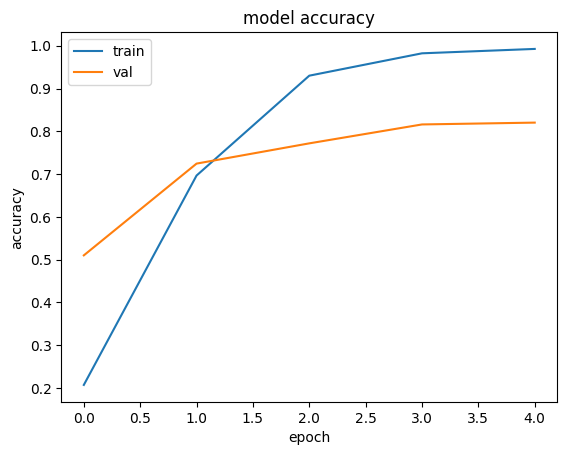

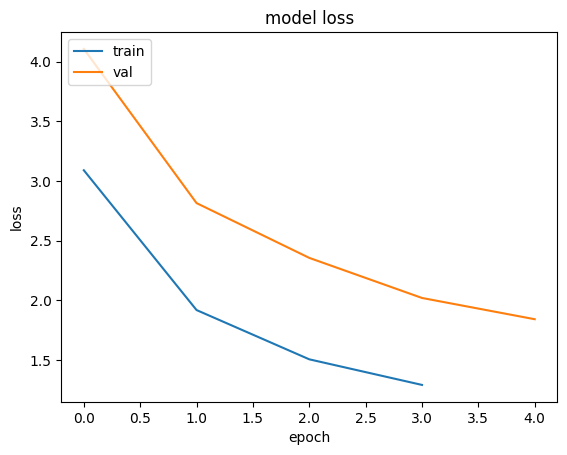

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Validation Accuracy**

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
val_predictions = model.predict(val_data)
val_predictions = np.argmax(val_predictions, axis=1)
val_labels_bin = label_binarize(val_labels, classes=range(105))
val_predictions_bin = label_binarize(val_predictions, classes=range(105))
accuracy = accuracy_score(val_labels_bin, val_predictions_bin)
print("validation Accuracy:", accuracy)


110/110 ━━━━━━━━━━━━━━━━━━━━ 32s 277ms/step
validation Accuracy: 0.8203592814371258


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


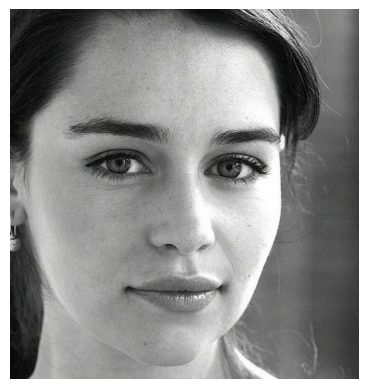

Predicted Label: Lindsey Morgan
True Label: Emilia Clarke31


In [87]:
import random
image_path=random.choice(filepaths)
image_filename = os.path.basename(image_path)
true_label = image_filename.split("_")[0]
image = plt.imread(image_path)
face = cv2.resize(image, (160, 160))
face = img_to_array(face)
face = preprocess_input(face)
features = model.predict(np.expand_dims(face, axis=0))
predicted_label = np.argmax(features)
predicted_name = celebrities[predicted_label]

plt.imshow(image)
plt.axis("off")
plt.show()

print("Predicted Label:", predicted_name)
print("True Label:", true_label)

In [29]:
# Function to perform face detection on a static photo
def detect_faces(detection_model, frame):
    # Perform face detection
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), [104., 177., 123.], False, True)
    detection_model.setInput(blob)
    detections = detection_model.forward()

    # Process the detections
    for i in range(0, detections.shape[2]):
        # Get the confidence (probability) of the current detection:
        confidence = detections[0, 0, i, 2]
        # Only consider detections if confidence is greater than a fixed minimum confidence:
        if confidence > 0.7:
            # Get the coordinates of the current detection:
            box = detections[0, 0, i, 3:7] * np.array([frame.shape[1], frame.shape[0], frame.shape[1], frame.shape[0]])
            (startX, startY, endX, endY) = box.astype("int")
            # Draw the detection and the confidence:
            text = "{:.3f}%".format(confidence * 100)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 255, 0), 2)
            cv2.putText(frame, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the result
    cv2.imshow("Frame", frame)
    
def recognize_faces(image,model):
    face = cv2.resize(image, (160, 160))
    face = img_to_array(face)
    face = preprocess_input(face)
    features = model.predict(np.expand_dims(face, axis=0))
    predicted_label = np.argmax(features)
    predicted_name = celebrities[predicted_label]
    cv2.putText(face, predicted_name, (10, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    print(predicted_name)
    return predicted_name


In [ ]:
random_image = np.random.choice(preprocessed_images)

In [28]:
#detect faces in live stream
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open camera.")
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to receive frame from camera.")
        break
    detect_faces(detection_model, frame)
    recognize_faces(frame,model)

    # Exit the loop if 'Esc' key is pressed
    key = cv2.waitKey(1)
    if key == 27:
        break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Robert De Niro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Robert De Niro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Robert De Niro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Robert De Niro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Robert De Niro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Robert De Niro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Robert De Niro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Robert De Niro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Robert De Niro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Robert De Niro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Robert De Niro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Robert De Niro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Robert De Niro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Robert De Niro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Keanu Reeves
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Keanu Reeves
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Keanu Reeves
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Robert De Niro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Robert De Niro

In [16]:
non_classified_dataset = 'C:\\Users\\Salma\\noClass\\lfw_funneled\\'
folders = os.listdir(non_classified_dataset)
print(len(folders))
print(folders)
#noclass contains paths of all images
noclass = [path  for name in folders for path in glob(non_classified_dataset+ name + '/*')]
print(len(noclass))


5749
['Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson', 'Aaron_Peirsol', 'Aaron_Pena', 'Aaron_Sorkin', 'Aaron_Tippin', 'Abbas_Kiarostami', 'Abba_Eban', 'Abdel_Aziz_Al-Hakim', 'Abdel_Madi_Shabneh', 'Abdel_Nasser_Assidi', 'Abdoulaye_Wade', 'Abdulaziz_Kamilov', 'Abdullah', 'Abdullah_Ahmad_Badawi', 'Abdullah_al-Attiyah', 'Abdullah_Gul', 'Abdullah_Nasseef', 'Abdullatif_Sener', 'Abdul_Majeed_Shobokshi', 'Abdul_Rahman', 'Abel_Aguilar', 'Abel_Pacheco', 'Abid_Hamid_Mahmud_Al-Tikriti', 'Abner_Martinez', 'Abraham_Foxman', 'Aby_Har-Even', 'Adam_Ant', 'Adam_Freier', 'Adam_Herbert', 'Adam_Kennedy', 'Adam_Mair', 'Adam_Rich', 'Adam_Sandler', 'Adam_Scott', 'Adelina_Avila', 'Adel_Al-Jubeir', 'Adisai_Bodharamik', 'Adolfo_Aguilar_Zinser', 'Adolfo_Rodriguez_Saa', 'Adoor_Gopalakarishnan', 'Adriana_Lima', 'Adriana_Perez_Navarro', 'Adrianna_Zuzic', 'Adrian_Annus', 'Adrian_Fernandez', 'Adrian_McPherson', 'Adrian_Murrell', 'Adrian_Nastase', 'Adrien_Brody', 'Afton_Smith', 'Agbani_Darego', 'Agnelo_Queiroz', 'Agn

In [17]:

no_class_dataset = []

for path in noclass:
    image_path =path
    image = cv2.imread(image_path)
    preprocessed_image = preprocess_input(image)

    preprocessed_image = cv2.resize(preprocessed_image, dsize = (IMG_W, IMG_H))
    preprocessed_image = preprocessed_image.astype(np.float32)/255.0

    feature_representation = model.predict(np.expand_dims(preprocessed_image, axis=0)).flatten()
    
    no_class_dataset.append(feature_representation)


len(no_class_dataset)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

13233

**Recognizing non-classified faces using cosine similarity**

In [ ]:

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
similarities = []
def recognizing(face,model):
    face = cv2.resize(image, (160, 160))
    face = img_to_array(face) 
    face = preprocess_input(face)
    features = model.predict(np.expand_dims(face, axis=0))#extract features
    predicted_label = np.argmax(features)
    predicted_name = celebrities[predicted_label]
    for feature_representation in no_class_dataset:
        similarity = cosine_similarity(np.expand_dims(features, axis=0), np.expand_dims(feature_representation, axis=0))
        similarities.append(similarity)
    max_similarity = max(similarities)

    # Check if the maximum similarity is above the threshold
    if max_similarity > 0.5:
        return "Not Classified"
    else:
        return predicted_name   


In [99]:
def detect(detection_model, frame):
    # Perform face detection
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), [104., 177., 123.], False, False)
    detection_model.setInput(blob)
    detections = detection_model.forward()

    # Process the detections
    for i in range(0, detections.shape[2]):
        # Get the confidence (probability) of the current detection:
        confidence = detections[0, 0, i, 2]
        # Only consider detections if confidence is greater than a fixed minimum confidence:
        if confidence > 0.7:
            # Get the coordinates of the current detection:
            box = detections[0, 0, i, 3:7] * np.array([frame.shape[1], frame.shape[0], frame.shape[1], frame.shape[0]])
            (startX, startY, endX, endY) = box.astype("int")
            # Draw the bounding box and predicted name on the frame
            cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 255, 0), 2)
            cv2.putText(frame, predicted_name, (startX, startY - 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    # Display the result
    cv2.imshow("Frame", frame)
    return predicted_name


In [ ]:
#detect faces in live stream
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open camera.")
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to receive frame from camera.")
        break
    detect_faces(detection_model, frame)
    perdicted_label=recognizing(frame, model)
    print(predicted_label)
    # Exit the loop if 'Esc' key is pressed
    key = cv2.waitKey(1)
    if key == 27:
        break

cap.release()
cv2.destroyAllWindows()